#### Emotion Classification Using SVM ####
This is an experiment of training a Support Vector Machine (SVM) on the task of multi-class emotion classification, using the dataset of EmoV-DB. The system should be able to identify and label emotions by analyzing various acoustic features within the audio signals.

<b>A brief description of EmoV-DB:</b>
* 6893 audio files (16kHz, 16-bit PCM WAV format, ~9h)
* Acted in North American English
* Two male and two female speakers

#### <b>Imports<b>

In [100]:
#%!pip install matplotlib pandas numpy librosa soundfile seaborn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import librosa
import soundfile
import os
import glob

import warnings; warnings.filterwarnings('ignore') #matplotlib and librosa display clash

An example of one of the utterances in the EmoV-DB dataset (bea_Amused/amused-1-15_0001.wav):

In [101]:
from IPython.display import Audio, display
audio_path = 'EmoVDB/bea_Amused/amused_1-15_0001.wav'
display(Audio(audio_path))

#### <b>Visualising the audio waveform</b>

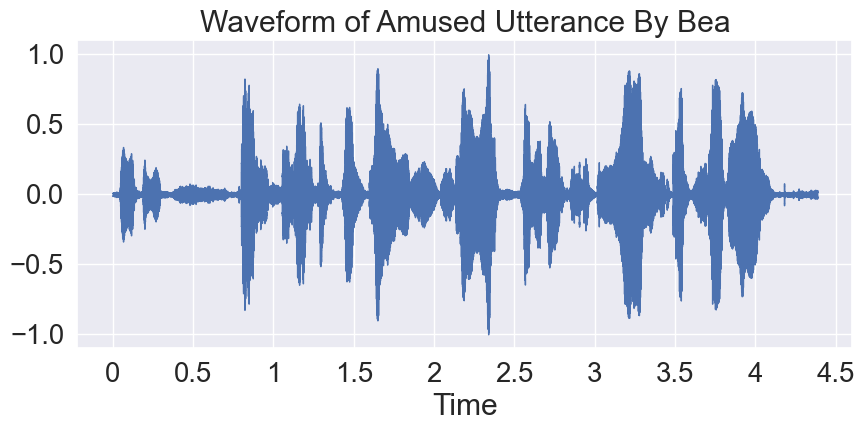

In [102]:
from matplotlib.colors import Normalize

with soundfile.SoundFile(audio_path) as audio:
    amused_waveform = audio.read(dtype='float32')
    sr = audio.samplerate
    plt.figure(figsize=(10,4))
    librosa.display.waveshow(amused_waveform, sr=sr)
    plt.title('Waveform of Amused Utterance By Bea')

#### <b>Visualising the power spectrogram and mel spectrogram</b>

Text(0.5, 1.0, 'Amused Power Spectrogram')

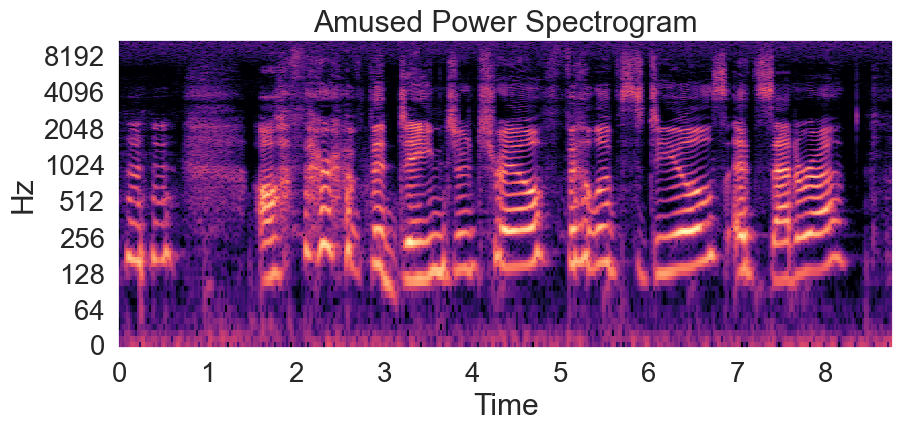

In [103]:
stft_amused = librosa.stft(amused_waveform)
plt.figure(figsize=(10,4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_amused), ref=np.max), x_axis='time', y_axis='log')
plt.title('Amused Power Spectrogram')

Text(0.5, 1.0, 'Amused Mel Spectrogram')

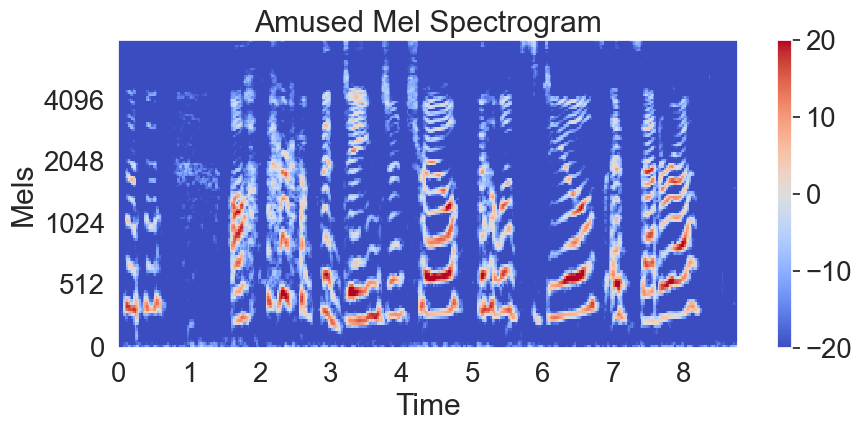

In [104]:
melspectrogram_amused = librosa.feature.melspectrogram(y=amused_waveform, sr=sr, n_mels=128, fmax=8000)
plt.figure(figsize=(10,4))
librosa.display.specshow(librosa.power_to_db(S=melspectrogram_amused, ref=np.mean), 
                         y_axis='mel', 
                         fmax=8000, 
                         x_axis='time',
                         norm=Normalize(vmin=-20,vmax=20))
plt.colorbar()
plt.ylabel('Mels')
plt.title('Amused Mel Spectrogram')

#### <b>Visualising the mel-frequency cepstral coefficients (MFCCs)</b>

Text(0.5, 1.0, 'Amused MFCCs')

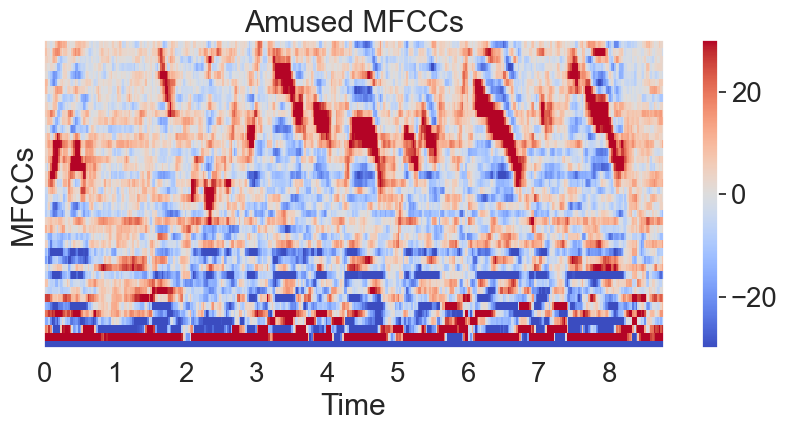

In [105]:
mfccs_amused = librosa.feature.mfcc(y=amused_waveform, sr=sr, n_mfcc=40)
plt.figure(figsize=(10,4))
librosa.display.specshow(mfccs_amused, x_axis='time', norm=Normalize(vmin=-30,vmax=30))
plt.colorbar()
plt.ylabel('MFCCs')
plt.title('Amused MFCCs')

#### <b>Visualising the chromagram

Text(0.5, 1.0, 'Amused Chromagram')

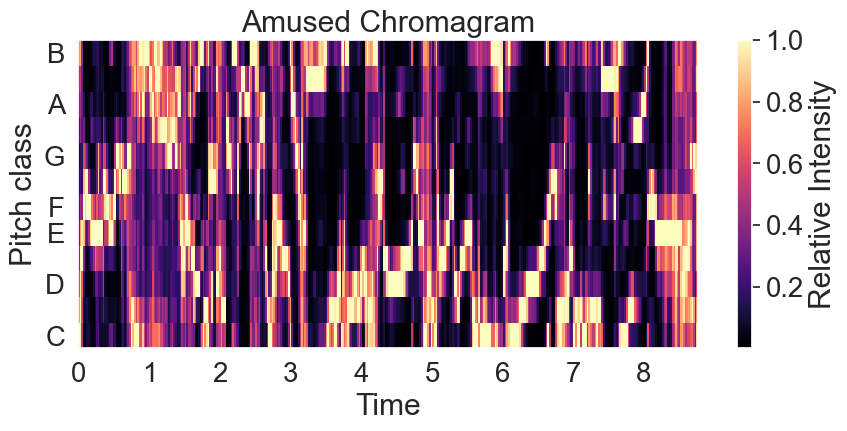

In [106]:
chromagram_amused = librosa.feature.chroma_stft(y=amused_waveform, sr=sr)
plt.figure(figsize=(10,4))
librosa.display.specshow(chromagram_amused, y_axis='chroma', x_axis='time')
plt.colorbar(label='Relative Intensity')
plt.title('Amused Chromagram')

#### <b>Feature extraction</b>
A mixture of features were chosen, including frequency-domain features to capture the distribution of energy within each audio sample, and some prosodic features to reveal the finer details of expressed emotion: <br>
* <b>MFCCs:</b> to describe the finer details of the spectral envelope shape
* <b>Spectral contrast:</b> to capture decibel difference of each frequency's sub-band's peak and valley
* <b>Fundamental frequency (F0):</b> to estimate the pitch of the signal
* <b>Speech rate:</b> estimated using the signal's spectral flux


In [107]:
#### Helper functions for feature extraction ####
def feature_mfccs(signal, sample_rate):
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=40).T, axis=0) 
    return mfc_coefficients

def feature_spec_contrast(signal, sample_rate):
    spec_contrast = np.mean(librosa.feature.spectral_contrast(y=signal, sr=sample_rate, n_bands=6).T, axis=0)
    return spec_contrast

def feature_pitch(signal, sample_rate):
    pitches, magnitudes = librosa.core.piptrack(y=signal, sr=sample_rate)
    pitch = np.mean(pitches[magnitudes > np.median(magnitudes)])
    return pitch

def feature_speech_rate(signal, sample_rate):
    duration = librosa.get_duration(y=signal, sr=sample_rate)
    if duration == 0:
        return 0.0 
    
    onset_env = librosa.onset.onset_strength(y=signal, sr=sample_rate)
    onset_times = librosa.frames_to_time(librosa.onset.onset_detect(onset_envelope=onset_env, sr=sample_rate))
    speech_rate = len(onset_times) / librosa.get_duration(y=signal, sr=sample_rate) 
    return speech_rate

In [108]:
def get_features(file):
    try:
        signal, sr = librosa.load(file, sr=16000, mono=True)

        if signal.size == 0 or np.all(signal == 0):
            print(f"Silent file: {file}")
            return None
        
        ##prosody##
        pitch = feature_pitch(signal, sr)
        speech_rate = feature_speech_rate(signal, sr)
        
        mfccs = feature_mfccs(signal, sr)
        spec_contrast = feature_spec_contrast(signal, sr)
        
        feature_matrix = np.hstack((pitch,
                                    speech_rate,
                                    mfccs,
                                    spec_contrast
        ))

        return feature_matrix
    
    except Exception as e:
        print(f"Error processing {file}: {e}")
        return None

#### <b>Mapping emotions within EmoV-DB to integers</b>

There are five total emotions expressed within the dataset: neutral, amused, anger, sleepiness and disgust.

In [109]:
emotions_emoVDB = {
    'neutral': 0,
    'amused': 1,
    'anger': 2,
    'sleepiness': 3,
    'disgust': 4
}

label_map = {v: k for k, v in emotions_emoVDB.items()}

#### <b>Loading the dataset</b>
The end goal is to get a one-dimensional feature vector.

In [110]:
def load_data():
    X, y, valid_file_names = [], [], []
    count = 0
    for file in glob.glob('EmoVDB/**/*.wav', recursive=True):
        file_name = os.path.basename(file)
        emotion_code = file_name.split('_')[0].lower()
        emotion = emotions_emoVDB.get(emotion_code)
        
        if emotion is None:
            continue 

        features = get_features(file)
        if features is None:
            continue
            
        X.append(features)
        y.append(emotion)
        valid_file_names.append(file)
        count+=1
        print('\r' + f' Processed {count}/6893 audio samples.', end=' ')

    print(f'Finished loading dataset.')
    return np.array(X), np.array(y), np.array(valid_file_names, dtype=str)

In [111]:
features, emotions, file_names = load_data() 

 Processed 6893/6893 audio samples. Finished loading dataset.


Doing a check to see if everything is 1D here:

In [112]:
lengths = [len(f) for f in features]
print("Unique feature lengths:", set(lengths))

Unique feature lengths: {49}


#### <b>An overview of the distribution of classes within EmoV-DB</b>

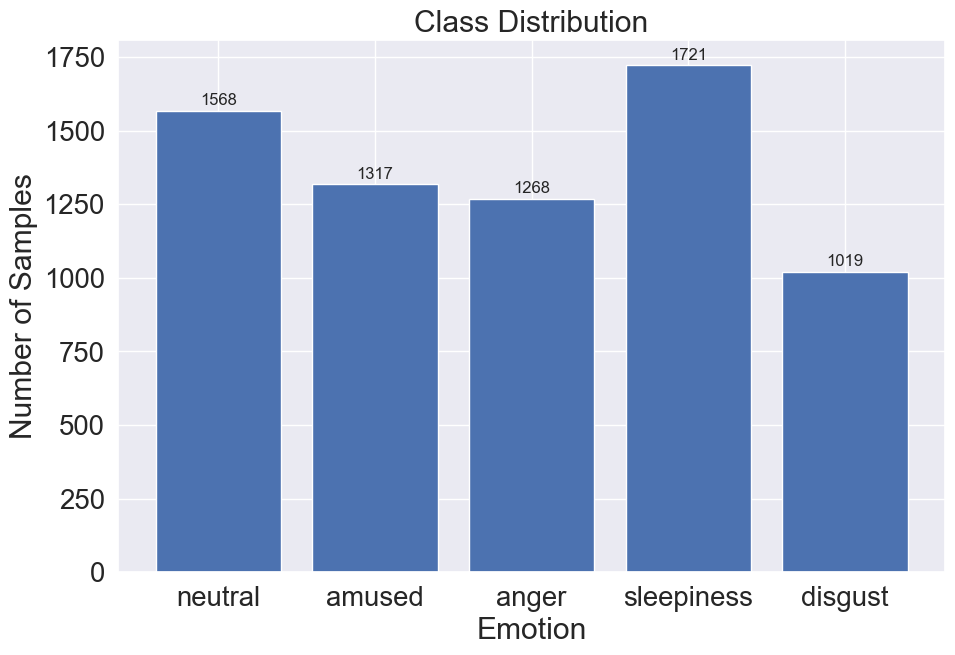

In [113]:
classes, count = np.unique(emotions, return_counts=True)
emotion_names = [label_map[c] for c in classes]

plt.figure(figsize=(10, 7))
plt.bar(emotion_names, count)

for i, c in enumerate(count):
    plt.text(i, c + 10, str(c), ha='center', va='bottom', fontsize=12)

plt.xlabel('Emotion')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.tight_layout()
plt.show()

It can be noted that there is imbalance of classes. Disgust is especially lacking in numbers, whereas sleepiness has the most samples out of all the classes.

#### <b>Training and testing the dataset using a SVM classifier. A train-validation-test split is used.

In [114]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features.copy())

##Unscaled train/test set##
X_train, X_test, y_train, y_test = train_test_split(
    features,
    emotions,
    test_size=0.2,
    random_state=42
)

##standard scaled test/train set##
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    features_scaled,
    emotions,
    test_size=0.2,
    random_state=42
)

In [115]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

#### Set up the parameter grid for gridsearch cross-validation for SVM ####
param_grid_SVC = {
    'C': [0.001, 0.001, 0.01, 1],
    'gamma': ['scale', 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

gridSVC = GridSearchCV(
    SVC(class_weight='balanced',
        random_state=42), 
    param_grid_SVC, 
    cv=5, 
    scoring='accuracy',
    verbose=1, 
    n_jobs=4
)

In [116]:
gridSVC.fit(X_train_scaled, y_train)
best_modelSVC = gridSVC.best_estimator_

print(f'==== Using SVM ====')
training_accuracySVC = best_modelSVC.score(X_train_scaled, y_train)
test_accuracySVC = best_modelSVC.score(X_test_scaled, y_test)

print(f'Training set accuracy with best parameters: {100*training_accuracySVC:.2f}%')
print(f'Test set accuracy with best parameters: {100*test_accuracySVC:.2f}%')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
==== Using SVM ====
Training set accuracy with best parameters: 99.11%
Test set accuracy with best parameters: 97.32%


              precision    recall  f1-score   support

     neutral       0.97      0.96      0.97       318
      amused       0.96      0.96      0.96       265
       anger       0.98      0.98      0.98       256
  sleepiness       1.00      0.98      0.99       321
     disgust       0.96      0.99      0.97       219

    accuracy                           0.97      1379
   macro avg       0.97      0.97      0.97      1379
weighted avg       0.97      0.97      0.97      1379



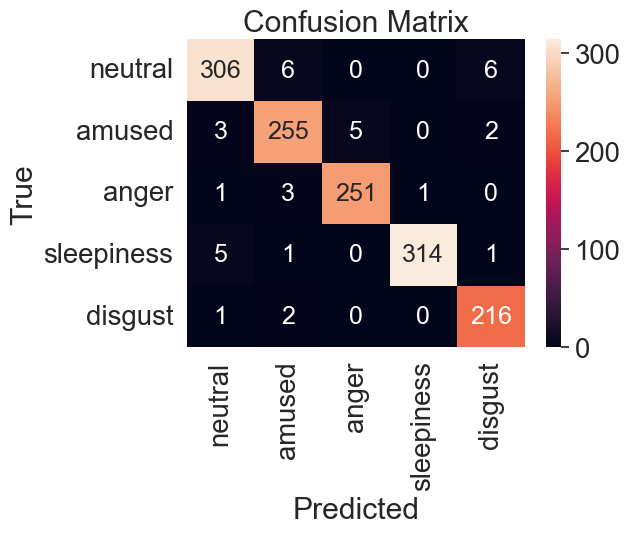

In [117]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_predSVC = best_modelSVC.predict(X_test_scaled)
print(classification_report(y_test,
                            y_predSVC,
                            target_names=[label_map[i] for i in sorted(label_map)]
                            ))

test_emo_pred = y_predSVC
test_emo_groundtruth = y_test

conf_matrix = confusion_matrix(y_test, y_predSVC, labels=sorted(label_map.keys()))
confmatrix_df = pd.DataFrame(
    conf_matrix,
    index=[label_map[i] for i in sorted(label_map)],
    columns=[label_map[i] for i in sorted(label_map)]
)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sn.set_theme(font_scale=1.8)
sn.heatmap(confmatrix_df,
           annot=True,
           annot_kws={'size':18},
           fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

As we can see, the accuracy rate, and other metrics (precision, recall, F1 score) all are rather high. There's a possibility of <b>overfitting</b>.

t-SNE visualisation:

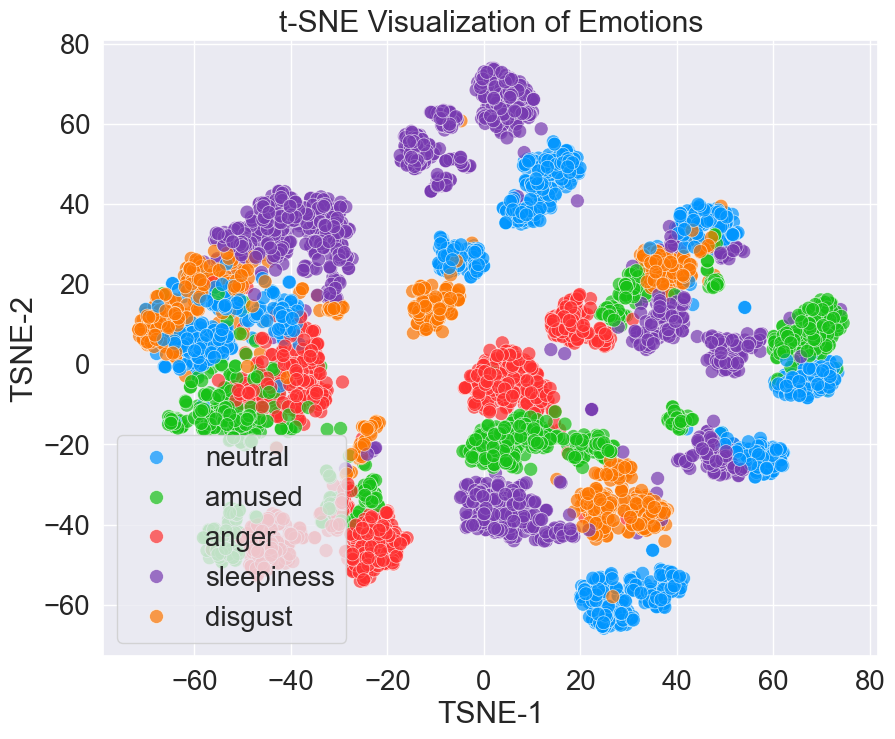

In [118]:
from sklearn.manifold import TSNE

emotion_order = [label_map[i] for i in sorted(label_map)] #ensure a consistent order for t-SNE colors
emotion_colors = {
    'neutral': "#0095ff", 
    'amused': "#17c117", 
    'anger': "#ff2f2f",     
    'sleepiness': "#773ab0",  
    'disgust': "#fd7600"
}

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=70)

X_tsne = tsne.fit_transform(X_train_scaled)
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE-1', 'TSNE-2'])
df_tsne['Emotion'] = pd.Categorical(
    pd.Series(y_train).map(label_map),
    categories=['neutral', 'amused', 'anger', 'sleepiness', 'disgust'],
    ordered=True
)

plt.figure(figsize=(10, 8))
plot = sn.scatterplot(x='TSNE-1',
                      y='TSNE-2',
                      hue='Emotion',
                      data=df_tsne,
                      hue_order=emotion_order,
                      palette=emotion_colors,
                      s=100,
                      alpha=0.7,
                      edgecolor='w',
                      linewidth=0.5)
plot.legend(loc='lower left')
plt.title('t-SNE Visualization of Emotions')
plt.show()

From the t-SNE visualisation of emotions, it can be observed that there is frequent overlap between the emotions <b>sleepiness, disgust, neutral</b>. These emotions aren't being classified as well, despite the high accuracy rate shown in the report - this indicates overfitting is indeed taking place, that the SVM is memorising answers rather than truly generalising.

Before that, some data augmentation to try to enhance the model's robustness to speaker/environmental variation.

In [65]:
#### Data augmentation helper functions ####

def add_white_noise(signal, noise_factor):
    '''
    Add white noise to the signal
    '''
    noise = np.random.normal(0, signal.std(), signal.size) 
    augmented_signal = signal + noise*noise_factor
    return augmented_signal

def time_stretch(signal, stretch_rate):
    '''
    Stretch the signal by a given stretch rate
    '''
    return librosa.effects.time_stretch(signal, rate=stretch_rate)

def pitch_scale(signal, sr, num_semitones):
    '''
    Scale the signal by a certain number of semitones
    '''
    return librosa.effects.pitch_shift(signal, sr=sr, n_steps=num_semitones)


When loading the augmented data, a counter is kept for the original class frequencies, such that the already-present class imbalance isn't enhanced further by the data augmentation done.

Subtle augmentation was used in order to preserve the emotion of the original audio. Too drastic of an augmentation may distort the emotional features.

In [77]:
def extract_features(signal, sr):
    pitch = feature_pitch(signal, sr)
    speech_rate = feature_speech_rate(signal, sr)
    mfccs = feature_mfccs(signal, sr)
    spec_contrast = feature_spec_contrast(signal, sr)
    
    return np.hstack((pitch,
                      speech_rate,
                      mfccs,
                      spec_contrast
                      ))

def load_augmented_data():
    '''
    Return dataset augmented with:
        * White noise
        * Time stretch
        * Pitch scale
    '''
    X_aug, y_aug = [], []
    class_counts = {} 
    count = 0

    min_class_size = 1200
    for file in glob.glob('EmoVDB/**/*.wav'):
        file_name = os.path.basename(file)
        emotion_code = file_name.split('_')[0].lower()

        if emotion_code not in emotions_emoVDB:
            continue 

        emotion = emotions_emoVDB[emotion_code]

        class_counts.setdefault(emotion, 0)
        if class_counts[emotion] >= min_class_size:
            continue

        signal, sr = librosa.load(file, sr=16000, mono=True)

        for aug_signal in [
            add_white_noise(signal, 0.02),
            time_stretch(signal, 0.97),
            pitch_scale(signal, sr, 2)
        ]:
            features = extract_features(aug_signal, sr)
            if features is not None:
                X_aug.append(features)
                y_aug.append(emotion)
                class_counts[emotion] += 1

        count += 1
        print('\r' + f'Processed {count} files', end=' ')
    
    print('\nAugmentation done.')
    return np.array(X_aug), np.array(y_aug)

features_aug, emotions_aug = load_augmented_data()
features_total = np.vstack([features, features_aug])
emotions_total = np.hstack([emotions, emotions_aug])
print(f'Augmented data size: {features_total.shape}')


Processed 2000 files 
Augmentation done.
Augmented data size: (12893, 49)


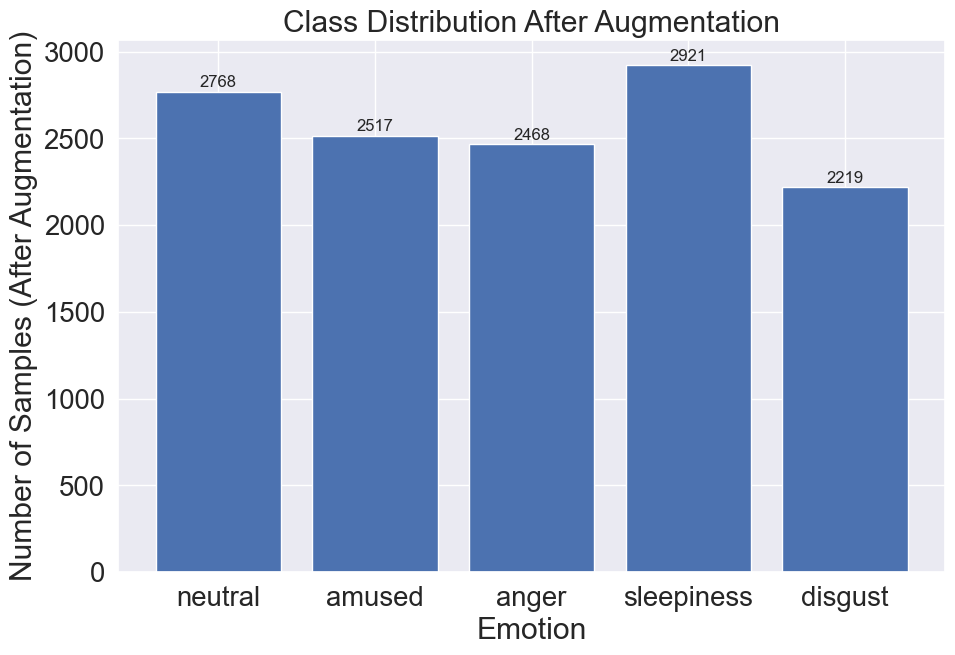

In [78]:
classes, count = np.unique(emotions_total, return_counts=True)
emotion_names = [label_map[c] for c in classes]

plt.figure(figsize=(10, 7))
plt.bar(emotion_names, count)

for i, c in enumerate(count):
    plt.text(i, c + 10, str(c), ha='center', va='bottom', fontsize=12)

plt.xlabel('Emotion')
plt.ylabel('Number of Samples (After Augmentation)')
plt.title('Class Distribution After Augmentation')
plt.tight_layout()
plt.show()

Compare the class distribution after augmentation to the original:<br>
![Original Class Distribution](classdistr1.png)

Scaling and splitting the augmented data:

In [79]:
features_aug_scaled = scaler.fit_transform(features_aug.copy())

X_aug_train, X_aug_test, y_aug_train, y_aug_test = train_test_split(
    features_aug,
    emotions_aug,
    test_size = 0.2,
    random_state = 70
)

X_aug_train_scaled, X_aug_test_scaled, _, _ = train_test_split(
    features_aug_scaled,
    emotions_aug,
    test_size = 0.2,
    random_state = 70
)

In [80]:
gridSVC.fit(X_aug_train_scaled, y_aug_train)
best_modelSVC = gridSVC.best_estimator_
training_accuracySVC = best_modelSVC.score(X_aug_train_scaled, y_aug_train)
test_accuracySVC = best_modelSVC.score(X_aug_test_scaled, y_aug_test)

print(f'==== Using SVM with data augmentation ====')
print(f'Training set accuracy with best parameters: {100*training_accuracySVC:.2f}%')
print(f'Test set accuracy with best parameters: {100*test_accuracySVC:.2f}%')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
==== Using SVM with data augmentation ====
Training set accuracy with best parameters: 99.81%
Test set accuracy with best parameters: 99.50%


              precision    recall  f1-score   support

     neutral       1.00      1.00      1.00       240
      amused       1.00      0.99      0.99       256
       anger       0.99      1.00      1.00       234
  sleepiness       0.99      1.00      0.99       238
     disgust       1.00      0.99      0.99       232

    accuracy                           0.99      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      0.99      0.99      1200



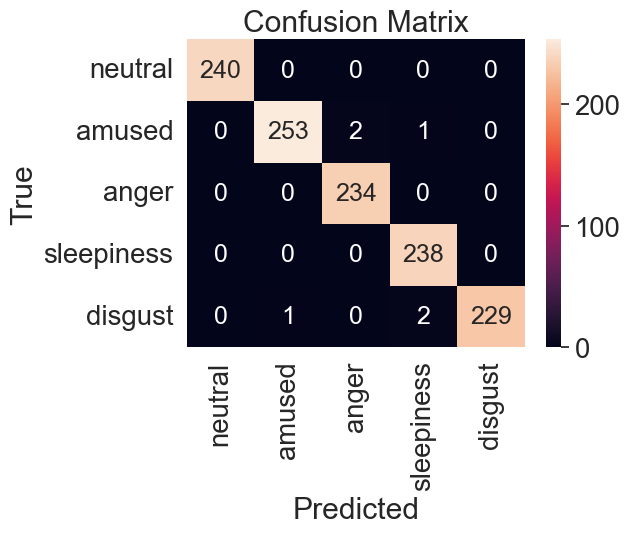

In [81]:
y_predSVC = best_modelSVC.predict(X_aug_test_scaled)
print(classification_report(
    y_aug_test,
    y_predSVC,
    target_names=[label_map[i] for i in sorted(label_map)]
))

test_emo_pred = y_predSVC
test_emo_groundtruth = y_aug_test

conf_matrix = confusion_matrix(y_aug_test, y_predSVC, labels=sorted(label_map.keys()))
confmatrix_df = pd.DataFrame(
    conf_matrix,
    index=[label_map[i] for i in sorted(label_map)],
    columns=[label_map[i] for i in sorted(label_map)]
)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sn.set_theme(font_scale=1.8)
sn.heatmap(confmatrix_df,
           annot=True,
           annot_kws={'size':18},
           fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

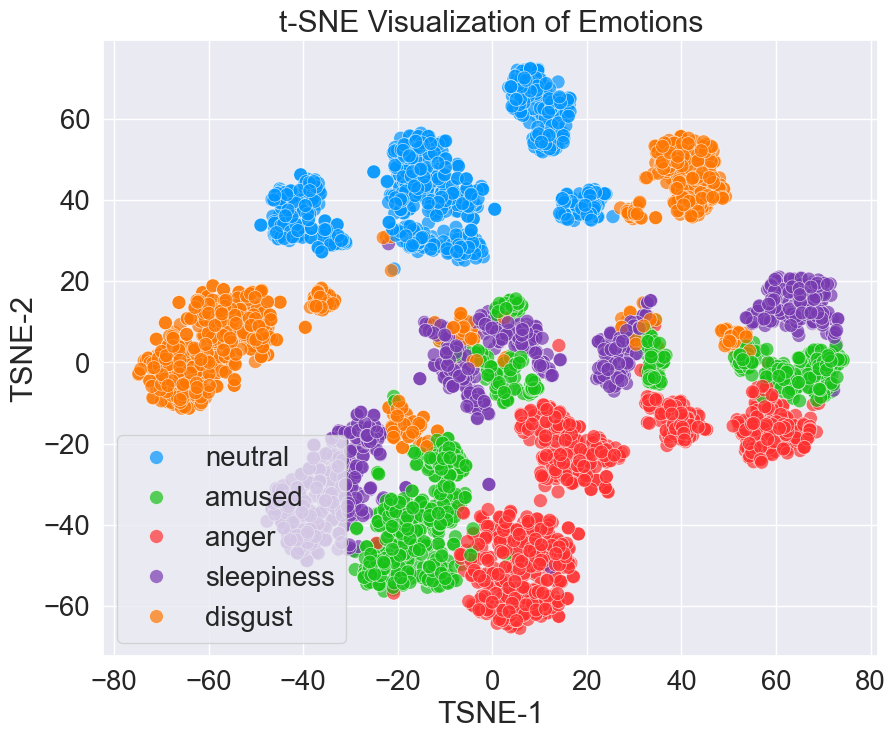

In [141]:
X_tsne = tsne.fit_transform(X_aug_train_scaled)
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE-1', 'TSNE-2'])
df_tsne['Emotion'] = pd.Categorical(
    pd.Series(y_aug_train).map(label_map),
    categories=['neutral', 'amused', 'anger', 'sleepiness', 'disgust'],
    ordered=True
)

plt.figure(figsize=(10, 8))
plot = sn.scatterplot(x='TSNE-1',
                      y='TSNE-2',
                      hue='Emotion',
                      data=df_tsne,
                      hue_order=emotion_order,
                      palette=emotion_colors,
                      s=100,
                      alpha=0.7,
                      edgecolor='w',
                      linewidth=0.5)
plot.legend(loc='lower left')
plt.title('t-SNE Visualization of Emotions')
plt.show()

Clusters are more distinct here, indicating better separation of emotion classes within the model's feature space.

#### <b>Speaker disjoint</b>

Now, the speakers will be split such that they do not overlap in the train and test sets.

In [30]:
from sklearn.model_selection import GroupShuffleSplit

def extract_speaker(file_path):
    '''
    Extract the speaker IDs from the file names:
        "bea_Angry" -> "bea"
    '''
    folder = os.path.basename(os.path.dirname(file_path))
    speaker_id = folder.split('_')[0]
    return speaker_id

speaker_ids = np.array([extract_speaker(f) for f in file_names])

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=70)
train_idx, test_idx = next(gss.split(features, emotions, groups=speaker_ids))

X_disjoint_train, y_disjoint_train = features[train_idx], emotions[train_idx]
X_disjoint_test, y_disjoint_test = features[test_idx], emotions[test_idx]

train_speakers = sorted(set(speaker_ids[train_idx]))
test_speakers = sorted(set(speaker_ids[test_idx]))

overlapping_speakers = set(train_speakers).intersection(set(test_speakers))
assert len(overlapping_speakers) == 0, f"Overlap in speakers: {overlapping_speakers}"

#### Print Summary of Split ####
print(f'===== Speaker Disjoint Result ======\n')
print(f'Total sample number: {len(X_disjoint_train) + len(X_disjoint_test)}')
print(f'Train sample number: {len(X_disjoint_train)}')
print(f'Test sample number: {len(X_disjoint_test)}\n')

print(f'Train set speakers ({len(train_speakers)} in total):')
print(', '.join(sorted(train_speakers)).title())

print(f'\nTest set speakers ({len(test_speakers)} in total):')
print(', '.join(sorted(test_speakers)).title())

===== Speaker Disjoint Result ======

Total sample number: 6893
Train sample number: 5103
Test sample number: 1790

Train set speakers (3 in total):
Bea, Josh, Sam

Test set speakers (1 in total):
Jenie


In [31]:
#### Scaling ####
X_dj_train_scaled = scaler.fit_transform(X_disjoint_train.copy())
X_dj_test_scaled = scaler.transform(X_disjoint_test.copy())

In [32]:
gridSVC.fit(X_dj_train_scaled, y_disjoint_train)
best_modelSVC = gridSVC.best_estimator_
training_accuracySVC = best_modelSVC.score(X_dj_train_scaled, y_disjoint_train)
test_accuracySVC = best_modelSVC.score(X_dj_test_scaled, y_disjoint_test)

print(f'==== Using SVM with speaker split ====')
print(f'Training set accuracy with best parameters: {100*training_accuracySVC:.2f}%')
print(f'Test set accuracy with best parameters: {100*test_accuracySVC:.2f}%')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
==== Using SVM with speaker split ====
Training set accuracy with best parameters: 99.04%
Test set accuracy with best parameters: 58.94%


              precision    recall  f1-score   support

     neutral       0.42      0.01      0.02       417
      amused       0.47      0.55      0.51       222
       anger       0.83      0.93      0.87       496
  sleepiness       0.50      1.00      0.66       466
     disgust       0.14      0.03      0.04       189

    accuracy                           0.59      1790
   macro avg       0.47      0.50      0.42      1790
weighted avg       0.53      0.59      0.49      1790



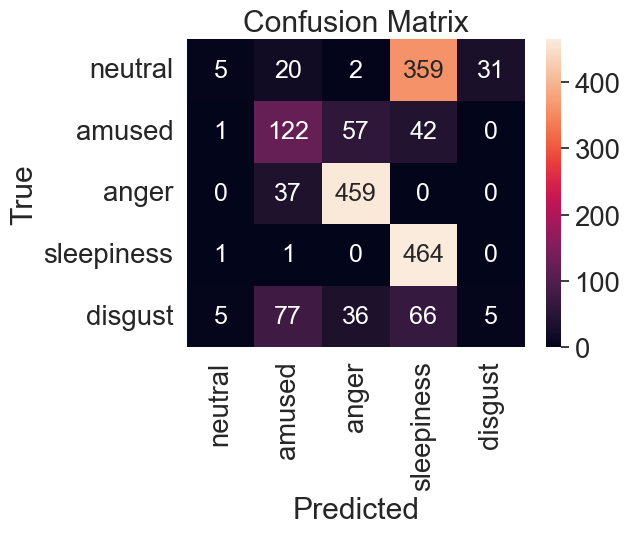

In [33]:
y_predSVC = best_modelSVC.predict(X_dj_test_scaled)
print(classification_report(y_disjoint_test,
                            y_predSVC,
                            target_names=[label_map[i] for i in sorted(label_map)]
                            ))

test_emo_pred = y_predSVC
test_emo_groundtruth = y_disjoint_test

conf_matrix = confusion_matrix(y_disjoint_test, y_predSVC, labels=sorted(label_map.keys()))
confmatrix_df = pd.DataFrame(
    conf_matrix,
    index=[label_map[i] for i in sorted(label_map)],
    columns=[label_map[i] for i in sorted(label_map)]
)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sn.set_theme(font_scale=1.8)
sn.heatmap(confmatrix_df,
           annot=True,
           annot_kws={'size':18},
           fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

The true performance of the model is revealed here. It has trouble accurately labelling 'neutral and 'disgust' especially, and to a lesser extent, 'amused'. In particular, many 'neutral' samples are inaccurately being labelled as 'sleepy', perhaps due to the natural overlap of these subtler emotional expressions.

Particularly poor recall for both 'neutral' and 'disgust', and particularly poor precision for 'disgust' as well. The model simply isn't detecting 'neutral'/'disgust' much at all.

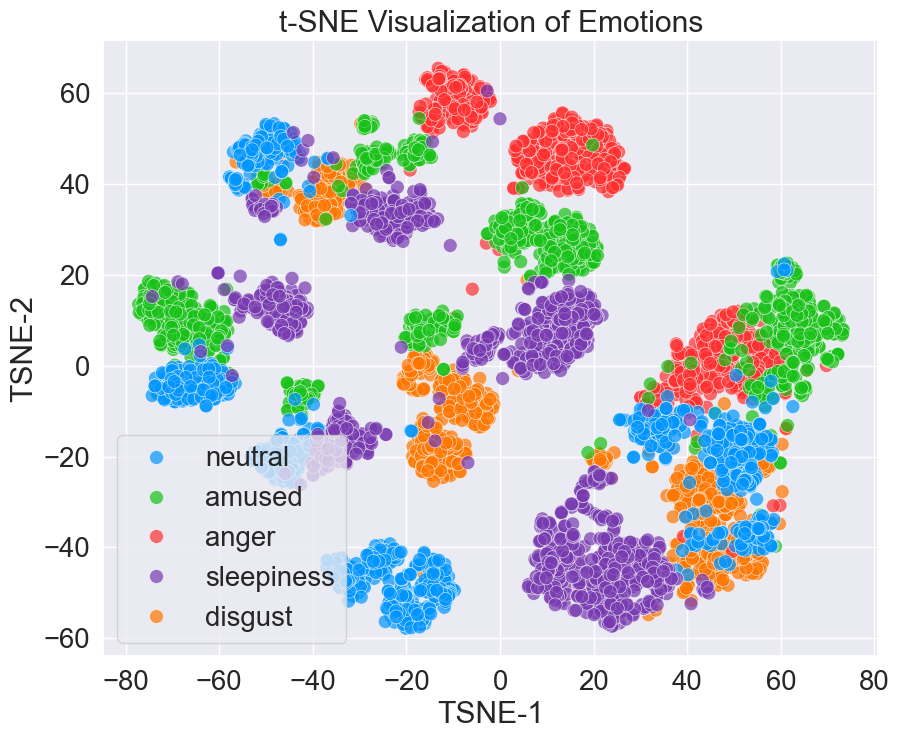

In [121]:
X_tsne = tsne.fit_transform(X_dj_train_scaled)
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE-1', 'TSNE-2'])
df_tsne['Emotion'] = pd.Categorical(
    pd.Series(y_disjoint_train).map(label_map),
    categories=['neutral', 'amused', 'anger', 'sleepiness', 'disgust'],
    ordered=True
)

plt.figure(figsize=(10, 8))
plot = sn.scatterplot(x='TSNE-1',
                      y='TSNE-2',
                      hue='Emotion',
                      data=df_tsne,
                      hue_order=emotion_order,
                      palette=emotion_colors,
                      s=100,
                      alpha=0.7,
                      edgecolor='w',
                      linewidth=0.5)
plot.legend(loc='lower left')
plt.title('t-SNE Visualization of Emotions')
plt.show()

The plot reveals overlapping and scattered clusters, which suggests that the model may not be effectively distinguishing between emotion categories.

In [ ]:
train_file_paths = file_names[train_idx]
train_emotions = emotions[train_idx]

X_aug, y_aug = [], []
class_count = {label: np.sum(y_train == label) for label in np.unique(y_train)}

min_class_size = 1500
for path, label in zip(train_file_paths, train_emotions):
    signal, sr = librosa.load(path, sr=16000)
    count = 0
    
    ####Augmentations####
    for aug_signal in [
        add_white_noise(signal, 0.02),
        time_stretch(signal, 0.97),
        pitch_scale(signal, sr, 2)
    ]:
        features_aug = extract_features(aug_signal, sr)

        #do a check to prevent enhancing class imbalance
        if class_count[label] < min_class_size and features_aug is not None:
            X_aug.append(features_aug)
            y_aug.append(label)
            class_count[label] += 1 
X_aug, y_aug = np.array(X_aug), np.array(y_aug)

print("Original data shape:", X_disjoint_train.shape)
print("Augmented data shape:", np.array(X_aug).shape)

#concatenate with original data 
X_disjoint_augmented = np.concatenate([X_disjoint_train, X_aug], axis=0)
y_disjoint_augmented = np.concatenate([y_disjoint_train, y_aug], axis=0)

print(f"\nAugmented training set size: {X_disjoint_augmented.shape[0]}")

Original data shape: (5103, 49)
Augmented data shape: (1986, 49)

Augmented training set size: 7089


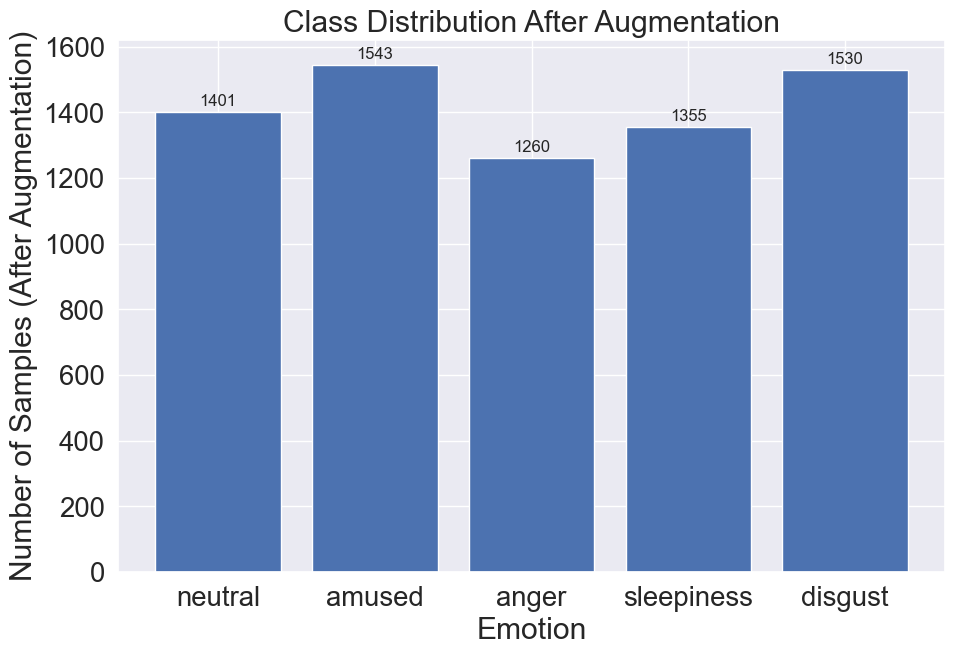

In [91]:
classes, count = np.unique(y_disjoint_augmented, return_counts=True)
emotion_names = [label_map[c] for c in classes]

plt.figure(figsize=(10, 7))
plt.bar(emotion_names, count)

for i, c in enumerate(count):
    plt.text(i, c + 10, str(c), ha='center', va='bottom', fontsize=12)

plt.xlabel('Emotion')
plt.ylabel('Number of Samples (After Augmentation)')
plt.title('Class Distribution After Augmentation')
plt.tight_layout()
plt.show()

Compare it to the original class distribution:<br>
![Original class distribution](classdistr1.png)

In [92]:
#### Scaling ####
X_da_train_scaled = scaler.fit_transform(X_disjoint_augmented.copy())
X_da_test_scaled = scaler.transform(X_disjoint_test.copy())

In [93]:
gridSVC.fit(X_da_train_scaled, y_disjoint_augmented)
best_modelSVC = gridSVC.best_estimator_
training_accuracySVC = best_modelSVC.score(X_da_train_scaled, y_disjoint_augmented)
test_accuracySVC = best_modelSVC.score(X_da_test_scaled, y_disjoint_test)

print(f'==== Using SVM with speaker split ====')
print(f'Training set accuracy with best parameters: {100*training_accuracySVC:.2f}%')
print(f'Test set accuracy with best parameters: {100*test_accuracySVC:.2f}%')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
==== Using SVM with speaker split ====
Training set accuracy with best parameters: 99.20%
Test set accuracy with best parameters: 74.64%


              precision    recall  f1-score   support

     neutral       0.63      0.98      0.76       417
      amused       0.62      0.60      0.61       222
       anger       0.81      0.92      0.86       496
  sleepiness       0.94      0.71      0.81       466
     disgust       0.62      0.03      0.05       189

    accuracy                           0.75      1790
   macro avg       0.73      0.65      0.62      1790
weighted avg       0.76      0.75      0.71      1790



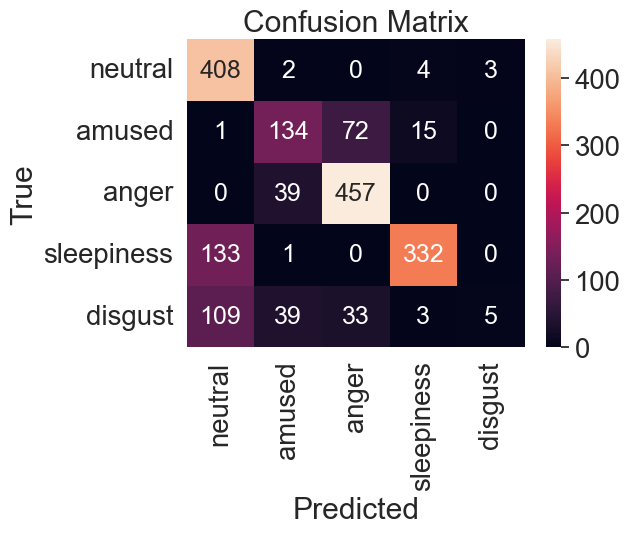

In [94]:
y_predSVC = best_modelSVC.predict(X_da_test_scaled)
print(classification_report(y_disjoint_test,
                            y_predSVC,
                            target_names=[label_map[i] for i in sorted(label_map)]
                            ))

test_emo_pred = y_predSVC
test_emo_groundtruth = y_disjoint_test

conf_matrix = confusion_matrix(y_disjoint_test, y_predSVC, labels=sorted(label_map.keys()))
confmatrix_df = pd.DataFrame(
    conf_matrix,
    index=[label_map[i] for i in sorted(label_map)],
    columns=[label_map[i] for i in sorted(label_map)]
)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sn.set_theme(font_scale=1.8)
sn.heatmap(confmatrix_df,
           annot=True,
           annot_kws={'size':18},
           fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

After data augmentation, the model showed improved performance on 'neutral', but poorer performance on 'sleepiness'. The model is still struggling greatly with 'disgust', with a large proportion of 'disgust' samples being misclassified as 'neutral' instead. 

Recall is especially poor when it comes to disgust - even though the model has 0.62 precision in recognising 'disgust', it's failing to recognise this specific emotion most of the time.

Again, the subtlety of changes between these emotions may be affecting the model's ability to distinguish the two.

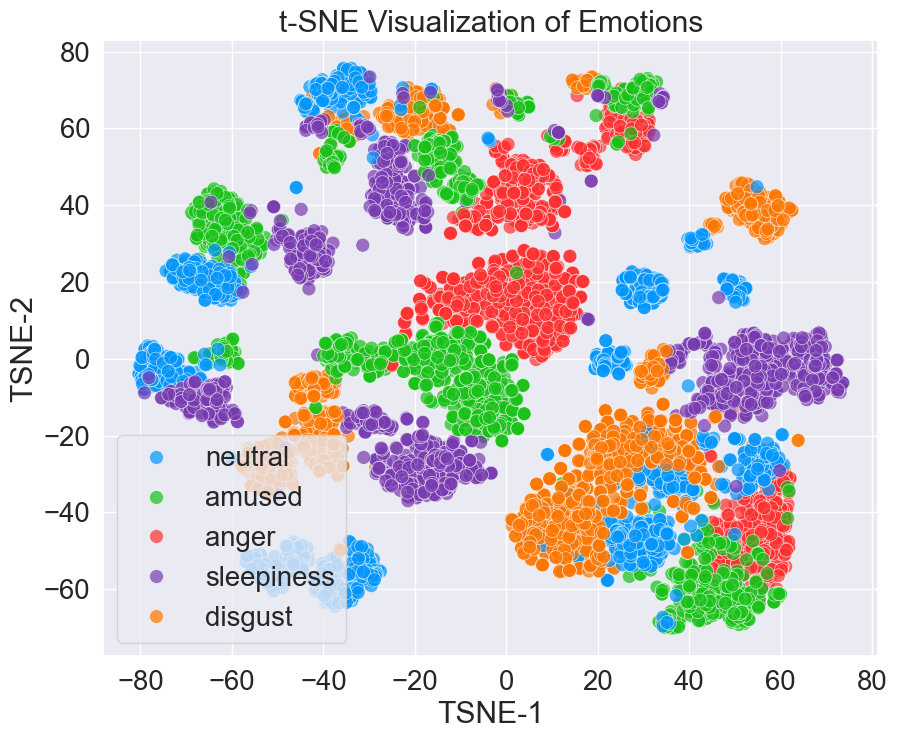

In [140]:
X_tsne = tsne.fit_transform(X_da_train_scaled)
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE-1', 'TSNE-2'])
df_tsne['Emotion'] = pd.Categorical(
    pd.Series(y_disjoint_augmented).map(label_map),
    categories=['neutral', 'amused', 'anger', 'sleepiness', 'disgust'],
    ordered=True
)

plt.figure(figsize=(10, 8))
plot = sn.scatterplot(x='TSNE-1',
                      y='TSNE-2',
                      hue='Emotion',
                      data=df_tsne,
                      hue_order=emotion_order,
                      palette=emotion_colors,
                      s=100,
                      alpha=0.7,
                      edgecolor='w',
                      linewidth=0.5)
plot.legend(loc='lower left')
plt.title('t-SNE Visualization of Emotions')
plt.show()

There is still much overlapping and scattering of the clusters. It can also be observed that there's more overlapping between 'amused' and 'anger', now - perhaps because these two emotions share higher arousal and vocal characteristics like increased energy and pitch. Data augmentation may exaggerate shared traits and lead to skewed predictions towards one class or another.

#### <b>Voice conversion using Seed-VC V1</b>

For additional data augmentation, Seed-VC was used to convert audio files in EmoV-DB to that of four other speakers, with references from the LibriSpeech corpus. This is with the goal of increasing speaker variation using the existing utterances from the EmoV-DB dataset.

An example of the reference audio (1320-122612-0000.flac renamed and converted to track2.wav):

In [145]:
display(Audio('refAudio/track1.wav'))

An example of an audio sample from EmoV-DB to be converted (bea_Amused/amused_1-15_0001.wav):

In [146]:
display(Audio('EmoVDB/bea_Amused/amused_1-15_0001.wav'))

An example of the converted audio (track1_amused_1-15_0001.wav):

In [147]:
display(Audio('ConvertedEmoVDB/track1_amused_1-15_0001.wav'))

#### <b>Loading the converted audio samples

In [64]:
def load_data_converted():
    X, y, valid_file_names = [], [], []
    count = 0
    for file in glob.glob('ConvertedEmoVDB/*.wav', recursive=True):
        file_name = os.path.basename(file)
        emotion_code = file_name.split('_')[1].lower()
        emotion = emotions_emoVDB.get(emotion_code)
        
        if emotion is None:
            continue 

        features = get_features(file)
        if features is None:
            continue
            
        X.append(features)
        y.append(emotion)
        valid_file_names.append(file)
        count+=1
        print('\r' + f' Processed {count} audio samples.', end=' ')

    print(f'Finished loading dataset.')
    return np.array(X), np.array(y), np.array(valid_file_names, dtype=str)

features_c, emotions_c, filenames_c = load_data_converted()

 Processed 6645 audio samples. Finished loading dataset.


We'll be splitting the speakers (differentiated by track name: track1, track2, etc.) for this converted dataset as well.

In [66]:
def extract_speaker_converted(file_path):
    '''
    Extract the speaker IDs from the file names:
        "track1_amused_1-15_0001-.wav" -> track1
    '''
    folder = os.path.basename(file_path)
    speaker_id = folder.split('_')[0]
    return speaker_id

speaker_ids = np.array([extract_speaker_converted(f) for f in filenames_c])

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=70)
train_idx, test_idx = next(gss.split(features_c, emotions_c, groups=speaker_ids))

X_cd_train, y_cd_train = features_c[train_idx], emotions_c[train_idx]
X_cd_test, y_cd_test = features_c[test_idx], emotions_c[test_idx]

train_speakers = sorted(set(speaker_ids[train_idx]))
test_speakers = sorted(set(speaker_ids[test_idx]))

overlapping_speakers = set(train_speakers).intersection(set(test_speakers))
assert len(overlapping_speakers) == 0, f"Overlap in speakers: {overlapping_speakers}"

#### Summary of Split #####
print(f'===== Speaker Disjoint Result ======\n')
print(f'Total sample number: {len(X_cd_train) + len(X_cd_test)}')
print(f'Train sample number: {len(X_cd_train)}')
print(f'Test sample number: {len(X_cd_test)}\n')

print(f'Train set speakers ({len(train_speakers)} in total):')
print(', '.join(sorted(train_speakers)).title())

print(f'\nTest set speakers ({len(test_speakers)} in total):')
print(', '.join(sorted(test_speakers)).title())

===== Speaker Disjoint Result ======

Total sample number: 6645
Train sample number: 4192
Test sample number: 2453

Train set speakers (3 in total):
Track1, Track3, Track4

Test set speakers (1 in total):
Track2


Now, to combine the converted audio with both speaker disjoint and data-augmented audio. The goal is to increase speaker variability and improve the model's ability to generalize across different speakers.

In [133]:
from collections import Counter

#target size for each class
target = 2100

#count the class frequences for the original and converted datasets
original_counts = Counter(y_disjoint_augmented)
converted_counts = Counter(y_cd_train)
selected_indices = []

#go over each class to determine how many samples to add
for class_id in np.unique(y_disjoint_train):
    original = original_counts[class_id]

    converted_class_indices = np.where(y_cd_train == class_id)[0]
    np.random.shuffle(converted_class_indices)

    #compute how many more samples to add
    needed = target - original
    available = len(converted_class_indices)
    add = min(needed, available)
    if add > 0:
        selected_indices.extend(converted_class_indices[:add])

#final samples to add
X_aug_selected = X_cd_train[selected_indices]
y_aug_selected = y_cd_train[selected_indices]

#merge with the previously-augmented dataset
X_train_final = np.vstack([X_disjoint_augmented, X_aug_selected])
y_train_final = np.hstack([y_disjoint_augmented, y_aug_selected])

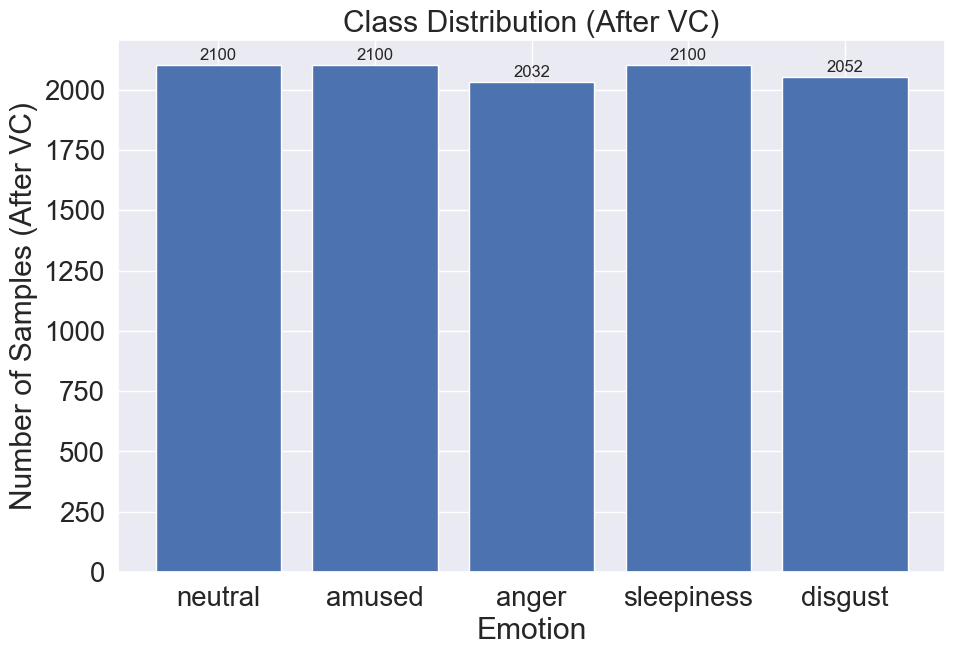

In [144]:
#Class distribution of emotions
classes, count = np.unique(y_train_final, return_counts=True)
emotion_names = [label_map[c] for c in classes]

# Plot class distribution
plt.figure(figsize=(10, 7))
plt.bar(emotion_names, count)

# Add counts above bars
for i, c in enumerate(count):
    plt.text(i, c + 10, str(c), ha='center', va='bottom', fontsize=12)

plt.xlabel('Emotion')
plt.ylabel('Number of Samples (After VC)')
plt.title('Class Distribution (After VC)')
plt.tight_layout()
plt.show()

The classes are balanced even further here. Compare it to the class distribution from the previous data-augmented dataset:

![](classdistr2.png)

In [135]:
X_train_scaled_new = scaler.fit_transform(X_train_final)
X_test_scaled_new = scaler.transform(X_disjoint_test)

In [136]:
gridSVC.fit(X_train_scaled_new, y_train_final)
best_modelSVC = gridSVC.best_estimator_
training_accuracySVC = best_modelSVC.score(X_train_scaled_new, y_train_final)
test_accuracySVC = best_modelSVC.score(X_test_scaled_new, y_disjoint_test)

print(f'==== Using SVM with speaker split ====')
print(f'Training set accuracy with best parameters: {100*training_accuracySVC:.2f}%')
print(f'Test set accuracy with best parameters: {100*test_accuracySVC:.2f}%')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


==== Using SVM with speaker split ====
Training set accuracy with best parameters: 91.59%
Test set accuracy with best parameters: 71.62%


              precision    recall  f1-score   support

     neutral       0.63      0.97      0.77       417
      amused       0.48      0.63      0.55       222
       anger       0.84      0.83      0.84       496
  sleepiness       0.89      0.69      0.78       466
     disgust       0.36      0.02      0.04       189

    accuracy                           0.72      1790
   macro avg       0.64      0.63      0.59      1790
weighted avg       0.71      0.72      0.68      1790



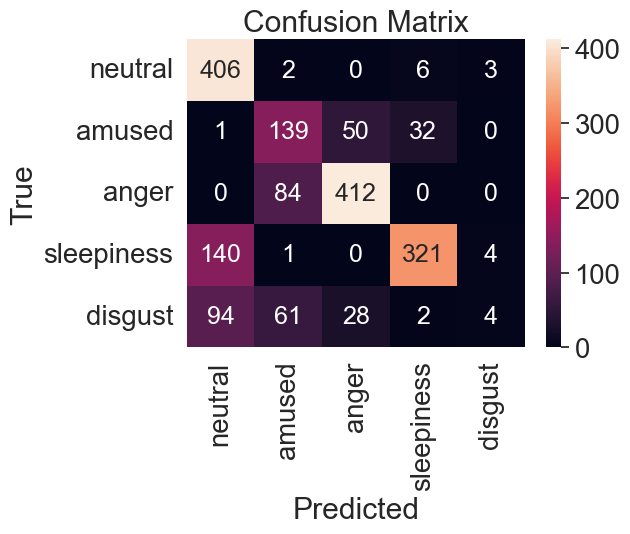

In [137]:
y_predSVC = best_modelSVC.predict(X_test_scaled_new)
print(classification_report(y_disjoint_test,
                            y_predSVC,
                            target_names=[label_map[i] for i in sorted(label_map)]
                            ))

test_emo_pred = y_predSVC
test_emo_groundtruth = y_disjoint_test

conf_matrix = confusion_matrix(y_disjoint_test, y_predSVC, labels=sorted(label_map.keys()))
confmatrix_df = pd.DataFrame(
    conf_matrix,
    index=[label_map[i] for i in sorted(label_map)],
    columns=[label_map[i] for i in sorted(label_map)]
)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sn.set_theme(font_scale=1.8)
sn.heatmap(confmatrix_df,
           annot=True,
           annot_kws={'size':18},
           fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Overall performance seems to have dropped. Particularly, the model is still performing poorly on 'disgust', and the model's performance on 'amused' has been affected negatively as well. 

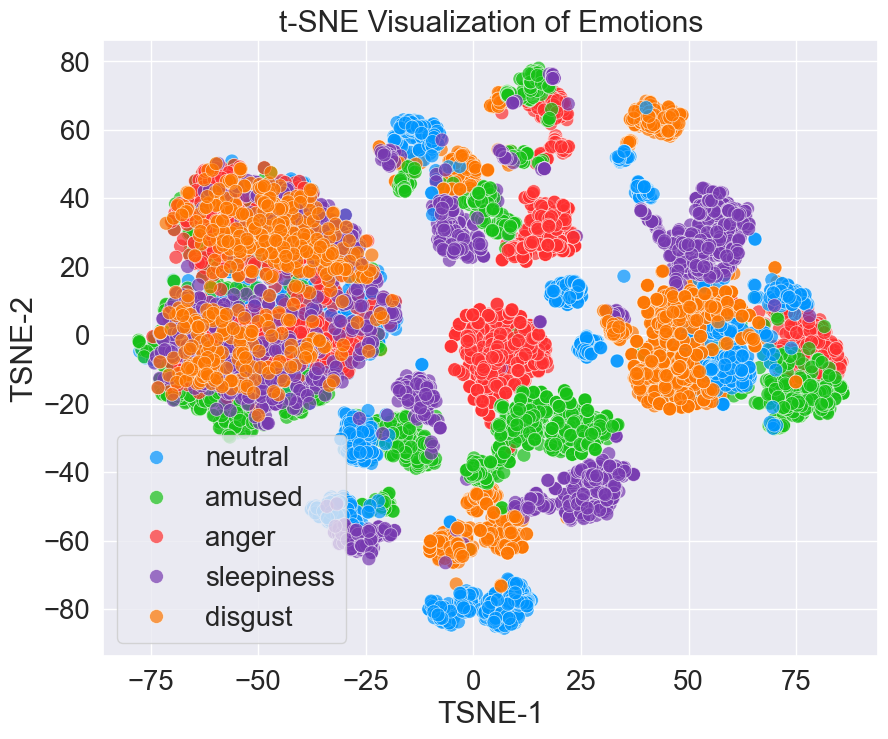

In [139]:
X_tsne = tsne.fit_transform(X_train_scaled_new)
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE-1', 'TSNE-2'])
df_tsne['Emotion'] = pd.Categorical(
    pd.Series(y_train_final).map(label_map),
    categories=['neutral', 'amused', 'anger', 'sleepiness', 'disgust'],
    ordered=True
)

plt.figure(figsize=(10, 8))
plot = sn.scatterplot(x='TSNE-1',
                      y='TSNE-2',
                      hue='Emotion',
                      data=df_tsne,
                      hue_order=emotion_order,
                      palette=emotion_colors,
                      s=100,
                      alpha=0.7,
                      edgecolor='w',
                      linewidth=0.5)
plot.legend(loc='lower left')
plt.title('t-SNE Visualization of Emotions')
plt.show()

The t-SNE plot here shows significant overlap of clusters; the model is struggling to separate the emotion classes clearly. This is likely due to the distortions and/or noise introduced when the audio files were put through voice conversion. These distortions may have altered the emotional features of the original audio, leading to difficulties in distinguishing the emotion classes.

#### <b>Conclusion</b>

SVMs can be effective when classifying strong emotions like anger or happiness, but may struggle with subtler emotions like sleepiness (as in EmoV-DB), disgust, or even boredom, as shown by the model's decreased performance for these more nuanced emotions. SVMs may be sensitive to noise in the data as well.

While SVMs can handle well-defined emotions, perhaps improvement is needed to better categorise low-intensity and/or similar emotions.

To improve future performance, adding a Convolutional Neural Network (CNN) to the SVM could enhance the model's ability to extract complex features from the audio data. This could help better classify subtler, more challenging emotions.